# Real-time Data Processing with Azure Databricks (and Event Hubs)

This notebook demonstrates the below architecture to build real-time data pipelines.
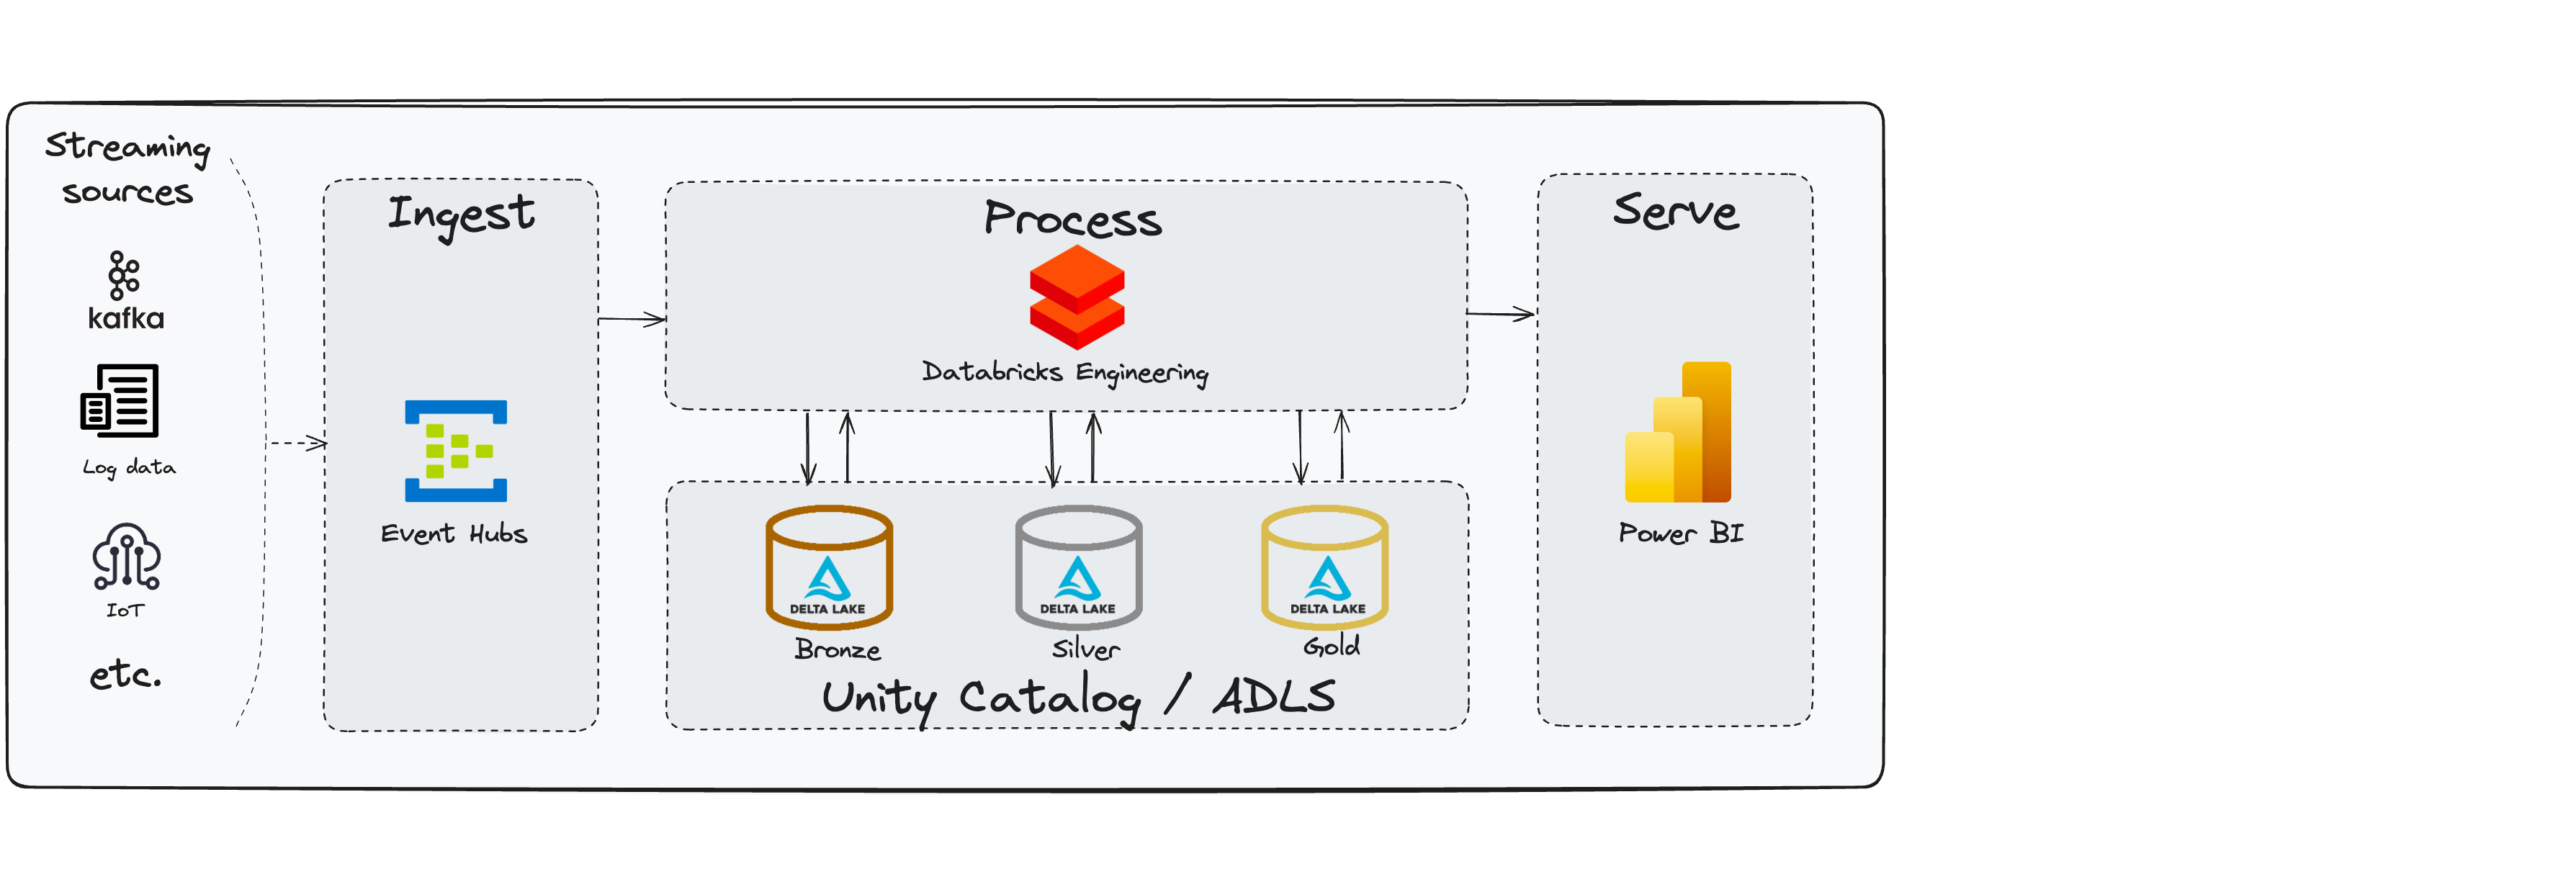


- Data Sources: Streaming data from IoT devices or social media feeds. (Simulated in Event Hubs)
- Ingestion: Azure Event Hubs for capturing real-time data.
- Processing: Azure Databricks for stream processing using Structured Streaming.
- Storage: Processed data stored Azure Data Lake (Delta Format).
- Visualisation: Data visualized using Power BI.


### Azure Services Required
- Databricks Workspace (Unity Catalog enabled)
- Azure Data Lake Storage (Premium)
- Azure Event Hub (Basic Tier)

### Azure Databricks Configuration Required
- Single Node Compute Cluster: `12.2 LTS (includes Apache Spark 3.3.2, Scala 2.12)`
- Maven Library installed on Compute Cluster: `com.microsoft.azure:azure-eventhubs-spark_2.12:2.3.22`

Importing the libraries.

In [0]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

The code block below creates the catalog and schemas for our solution. 

The approach utilises a multi-hop data storage architecture (medallion), consisting of bronze, silver, and gold schemas within a 'streaming' catalog. 

In [0]:
try:
    spark.sql("create catalog streaming;")
except:
    print('check if catalog already exists')

try:
    spark.sql("create schema streaming.bronze;")
except:
    print('check if bronze schema already exists')

try:
    spark.sql("create schema streaming.silver")
except:
    print('check if silver schema already exists')

try:
    spark.sql("create schema streaming.gold;")
except:
    print('check if gold schema already exists')

check if catalog already exists
check if bronze schema already exists
check if silver schema already exists
check if gold schema already exists


#### Bronze Layer

Set up Azure Event hubs connection string.

In [0]:
# Config
# Replace with your Event Hub namespace, name, and key
connectionString = "Paste connection string here"
eventHubName = "Type event hub name here"

ehConf = {
  'eventhubs.connectionString' : sc._jvm.org.apache.spark.eventhubs.EventHubsUtils.encrypt(connectionString),
  'eventhubs.eventHubName': eventHubName
}

Reading and writing the stream to the bronze layer.

In [0]:
# Reading stream: Load data from Azure Event Hub into DataFrame 'df' using the previously configured settings
df = spark.readStream \
    .format("eventhubs") \
    .options(**ehConf) \
    .load() \

# Displaying stream: Show the incoming streaming data for visualization and debugging purposes
df.display()

# Writing stream: Persist the streaming data to a Delta table 'streaming.bronze.weather' in 'append' mode with checkpointing
df.writeStream\
    .option("checkpointLocation", "/mnt/streaming/bronze/weather")\
    .outputMode("append")\
    .format("delta")\
    .toTable("streaming.bronze.weather")

#### Silver Layer

Defining the schema for the JSON object.

In [0]:
# Defining the schema for the JSON object
json_schema = StructType([
    StructField("temperature", IntegerType()),
    StructField("humidity", IntegerType()),
    StructField("windSpeed", IntegerType()),
    StructField("windDirection", StringType()),
    StructField("precipitation", IntegerType()),
    StructField("conditions", StringType())
])

Reading, transforming and writing the stream from the bronze to the silver layer.

In [0]:
# Reading and Transforming: Load streaming data from the 'streaming.bronze.weather' Delta table, cast 'body' to string, parse JSON, and select specific fields
df = spark.readStream\
    .format("delta")\
    .table("streaming.bronze.weather")\
    .withColumn("body", col("body").cast("string"))\
    .withColumn("body",from_json(col("body"), json_schema))\
    .select("body.temperature", "body.humidity", "body.windSpeed", "body.windDirection", "body.precipitation", "body.conditions", col("enqueuedTime").alias('timestamp'))

# Displaying stream: Visualize the transformed data in the DataFrame for verification and analysis
df.display()

# Writing stream: Save the transformed data to the 'streaming.silver.weather' Delta table in 'append' mode with checkpointing for data reliability
df.writeStream\
    .option("checkpointLocation", "/mnt/streaming/silver/weather")\
    .outputMode("append")\
    .format("delta")\
    .toTable("streaming.silver.weather")

#### Gold Layer

Reading, aggregating and writing the stream from the silver to the gold layer.

In [0]:
# Aggregating Stream: Read from 'streaming.silver.weather', apply watermarking and windowing, and calculate average weather metrics
df = spark.readStream\
    .format("delta")\
    .table("streaming.silver.weather")\
    .withWatermark("timestamp", "5 minutes") \
    .groupBy(window("timestamp", "5 minutes")) \
    .agg(avg("temperature").alias('temperature'), avg("humidity").alias('humidity'), avg("windSpeed").alias('windSpeed'), avg("precipitation").alias('precipitation'))\
	.select('window.start', 'window.end', 'temperature', 'humidity', 'windSpeed', 'precipitation')

# Displaying Aggregated Stream: Visualize aggregated data for insights into weather trends
df.display()

# Writing Aggregated Stream: Store the aggregated data in 'streaming.gold.weather_aggregated' with checkpointing for data integrity
df.writeStream\
    .option("checkpointLocation", "/mnt/streaming/weather_summary")\
    .outputMode("append")\
    .format("delta")\
    .toTable("streaming.gold.weather_summary")